In [1]:
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Step 1: Load the GeoDataFrame with polygons and calculate the area of each polygon
votes_gdf = gpd.read_file('fl_2016/fl_2016.shp')

votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # calculate votes for blue per precinct
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']  # calculate votes for red per precinct

# Step 2: Reproject to a projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)  # You can change EPSG code to a suitable one for your area

# Step 3: Calculate the area using the projected GeoDataFrame
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area

# Define the attribute columns to be rasterized
selected_columns = ['blue', 'red']

# Step 4: Define the bounds and raster properties
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Step 5: Rasterize each attribute column separately into bands with fractional values
raster_bands = []
pixel_area = pixel_size ** 2  # Calculate the area of a single pixel

for col in selected_columns:
    # Generate shapes for rasterization, scaling by pixel area
    shapes = (
        (geom, (value / area) * pixel_area) 
        for geom, value, area in zip(votes_gdf_projected.geometry, votes_gdf_projected[col], votes_gdf_projected['area'])
    )
    
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'  # Using float to handle fractional values
    )
    raster_bands.append(raster_band)

# Step 6: Verify the results
total_population = sum(band.sum() for band in raster_bands)
original_population = votes_gdf['blue'].sum() + votes_gdf['red'].sum()

print(f"Total population from raster: {total_population}")
print(f"Original total population: {original_population}")


Total population from raster: 18182874.0
Original total population: 18080140


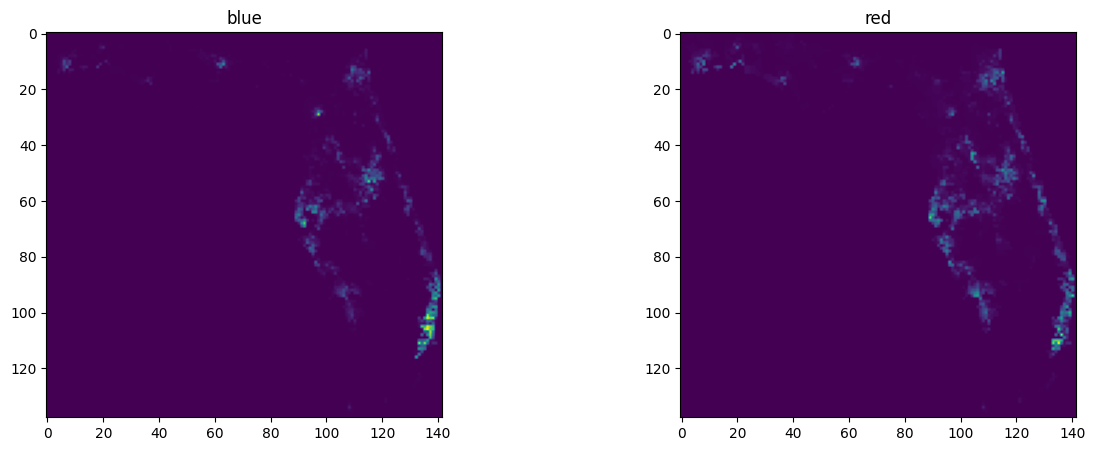

In [2]:
# Visualize one of the raster bands for verification (optional)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(selected_columns), figsize=(15, 5))
for i, band in enumerate(raster_bands):
    axs[i].imshow(band, cmap='viridis')
    axs[i].set_title(f'{selected_columns[i]}')
plt.show()

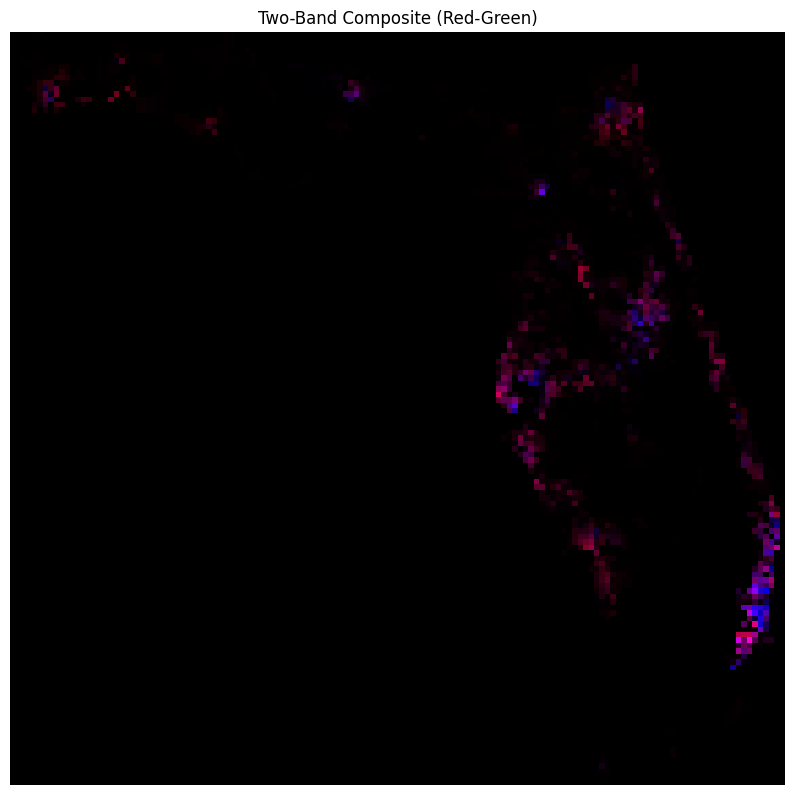

In [3]:
import numpy as np

# Get the two bands
blue_band = raster_bands[0]
red_band = raster_bands[1]

# Normalize bands to [0, 1] for visualization
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

blue_norm = normalize(blue_band)
red_norm = normalize(red_band)
green_norm = np.zeros_like(red_norm)  # Set green channel to zero

# Stack bands to create an RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Two-Band Composite (Red-Green)')
plt.axis('off')
plt.show()

In [4]:
# create a GeoDataFrame with the boundaries of congressional districts
districts_gdf = gpd.read_file('fl_2016_congressional_districts/fl_2016_congressional_districts.shp')

# project into same scale
districts_gdf_projected = districts_gdf.to_crs(epsg=3857)

# assign id to each district
districts_gdf_projected["poly_id"] = np.arange(len(districts_gdf_projected))

# get polygon boundaries
boundary_gdf = districts_gdf_projected.copy()
boundary_gdf['geometry'] = boundary_gdf.geometry.boundary

In [5]:

# Rasterize the boundaries
boundary_shapes = ((geom, 1) for geom in boundary_gdf.geometry)
boundary_mask = rasterize(
    shapes=boundary_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Also rasterize polygon IDs
poly_id_shapes = ((geom, pid) for geom, pid in zip(districts_gdf_projected.geometry, districts_gdf_projected['poly_id']))
poly_id_raster = rasterize(
    shapes=poly_id_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='int32'
)

# mask pixels that have non-zero value and in a border
mask = ((blue_band > 0) | (red_band > 0)) & (boundary_mask > 0)

# get all candidate pixels
candidate_pixels = np.argwhere(mask)

# get pixels that are in the border of two districts
def get_neighbors(r, c, arr):
    """Get the values of the 8-connected neighbors and the pixel itself."""
    rows = [r-1, r-1, r-1, r, r, r+1, r+1, r+1]
    cols = [c-1, c, c+1, c-1, c+1, c-1, c, c+1]
    vals = []
    for rr, cc in zip(rows, cols):
        if 0 <= rr < arr.shape[0] and 0 <= cc < arr.shape[1]:
            vals.append(arr[rr, cc])
    return vals

# Filter candidate pixels to those between exactly two distinct polygons
valid_pixels = []
for (row, col) in candidate_pixels:
    # Get polygon IDs of neighbors
    neighbor_ids = get_neighbors(row, col, poly_id_raster)
    # Include the pixel itself to consider its own polygon ID
    center_id = poly_id_raster[row, col]
    all_ids = neighbor_ids + [center_id]
    
    # Count distinct non-zero IDs
    distinct_ids = set(all_ids) - {0}
    if len(distinct_ids) == 2:
        valid_pixels.append((row, col))

Randomly selected boundary pixel at (row 13, col 109):
  Value in Blue Band: 25860.7578125
  Value in Red Band: 1760.4283447265625


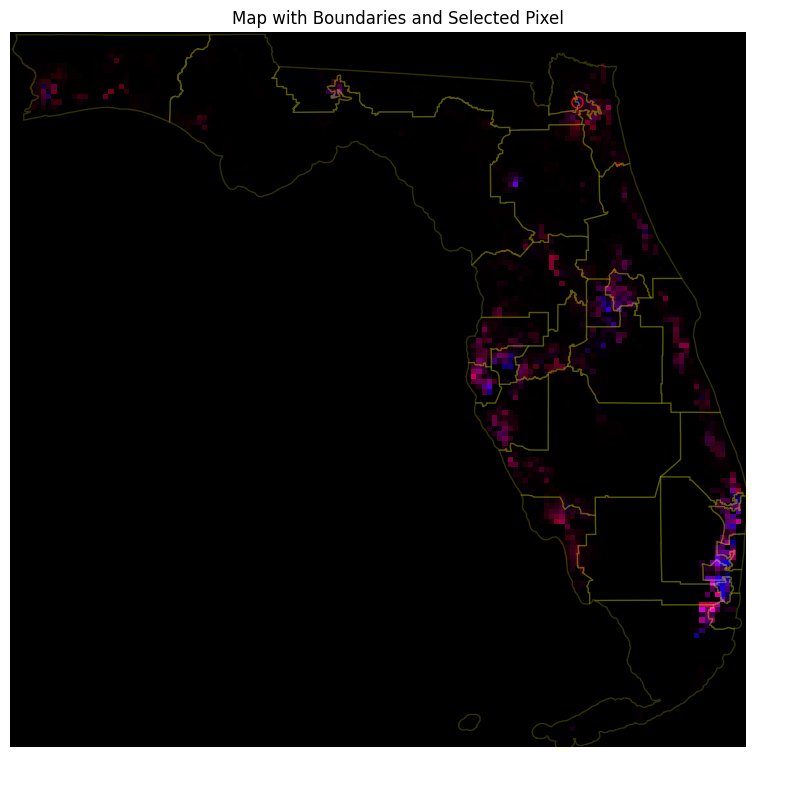

In [6]:
import random

# random sample a pixel and display 
if len(valid_pixels) == 0:
    print("No valid boundary pixels found.")
else:
    random_index = random.randint(0, len(valid_pixels) - 1)
    row, col = valid_pixels[random_index]

    blue_value = blue_band[row, col]
    red_value = red_band[row, col]

    print(f"Randomly selected boundary pixel at (row {row}, col {col}):")
    print(f"  Value in Blue Band: {blue_value}")
    print(f"  Value in Red Band: {red_value}")

    # Plot the RGB image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb, origin='upper')

    # Mark the selected pixel
    ax.plot(col, row, 'ro', markersize=8, markerfacecolor='none', markeredgecolor='red')

    # Convert line geometries from projected coords to pixel coords and plot them
    inv_transform = ~transform  # Inverse transform to go from map coords to pixel coords
    for geom in boundary_gdf.geometry:
        # Each geometry is a LineString or MultiLineString
        if geom is None:
            continue
        
        if geom.geom_type == 'MultiLineString':
            lines = geom.geoms
        else:
            lines = [geom]

        for line in lines:
            x_coords, y_coords = line.xy
            # Convert to pixel coordinates
            pixel_coords = [inv_transform * (x, y) for x, y in zip(x_coords, y_coords)]
            # pixel_coords is now a list of (col, row) tuples
            cols, rows = zip(*pixel_coords)
            ax.plot(cols, rows, color='yellow', linewidth=1, alpha=0.2)

    ax.set_title('Map with Boundaries and Selected Pixel')
    ax.axis('off')
    plt.show()